# Data Mining Final Term Project:

**Name: Deep Bipinbhai Patel</br>
ID: 1001765854**

*Kaggle Competition* : https://www.kaggle.com/jvanelteren/boardgamegeek-reviews</br>
Dataset set can be downloaded from the above kaggle link:
</br></br>
### Our goal is to predict the rating of the movie based on the comment provided by the users.

In [90]:
pip install pyspark


In [91]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [0]:
#import all the required library:
import pandas as pd 
import numpy as np
import re
import pickle
from tqdm import tqdm
import dask.dataframe as dd
from pyspark.sql import *
from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
stop = stopwords.words('english')
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import accuracy_score

### **Steps to achieve our goal:**
<pre>
1. Fetch Data
2. Data Cleaning and Exploration
3. Word Count- Count Vectorizer
4. TF-IDF
5. Build Models
          A. Mulitnomial NM
          B. Random Forest
             i. K- fold
          C. SVC
             i. Hyper-parameter tuning  
6. Compare different models and select best model 
</pre> 

# 1.Fetch Data

In [93]:
#let's check the no or records we are dealing with
%%time
path='/content/drive/My Drive/boardgamegeek-reviews/bgg-13m-reviews.csv'
with open(path) as file:
    row_count = len(file.readlines())

print('Total rows='+str(row_count))

Total rows=13170074
CPU times: user 6.2 s, sys: 3.18 s, total: 9.38 s
Wall time: 9.39 s


**We are dealing with huge data above 13 million so we need to get optimized appproach to deal with record.</br>**
![alt text](https://miro.medium.com/max/727/1*qTPZQC50pShw9hjpCg1uYQ.png)
</br>
A. First we will try get data in chunks

In [94]:
#before we start getting data in chunks first we need to know fetures we are dealing with and type of datatype of values
data_tmp = pd.read_csv(path, nrows=5)#let's take top 5 records
data_tmp.head()

,Unnamed: 0,user,rating,comment,ID,name
0,0,sidehacker,10.0,NaN,13,Catan
1,1,Varthlokkur,10.0,NaN,13,Catan
2,2,dougthonus,10.0,"Currently, this sits on my list as my favorite...",13,Catan
3,3,cypar7,10.0,"I know it says how many plays, but many, many ...",13,Catan
4,4,ssmooth,10.0,NaN,13,Catan


In [95]:
data_tmp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  5 non-null      int64  
 1   user        5 non-null      object 
 2   rating      5 non-null      float64
 3   comment     2 non-null      object 
 4   ID          5 non-null      int64  
 5   name        5 non-null      object 
dtypes: float64(1), int64(2), object(3)
memory usage: 368.0+ bytes


In [0]:
#Now let's set chucnk size equal to 1 million
chunk_size = 1_000_000

In [0]:
# Let us set the column name for our dataframe
train_types = {'Unnamed: 0': 'int64',
              'user': 'str', 
              'rating': 'float32',
              'comment': 'str',
              'ID': 'int64',
              'name': 'str'}
columns = list(train_types.keys())

In [98]:
%%time
data_list = [] # list to store chunks

for data_chunk in tqdm(pd.read_csv(path, usecols=columns, dtype=train_types, chunksize=chunk_size)):
  data_list.append(data_chunk)

train_data_frame = pd.concat(data_list) #Here we are merging all the data frames in one

del data_list # To avoid unwanted space occupation let us release data_list

train_data_frame.info()  #Let's check our obtained dataframe info

14it [00:18,  1.31s/it]


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13170073 entries, 0 to 13170072
Data columns (total 6 columns):
 #   Column      Dtype  
---  ------      -----  
 0   Unnamed: 0  int64  
 1   user        object 
 2   rating      float32
 3   comment     object 
 4   ID          int64  
 5   name        object 
dtypes: float32(1), int64(2), object(3)
memory usage: 552.6+ MB
CPU times: user 22.1 s, sys: 1.37 s, total: 23.5 s
Wall time: 24.1 s


In [99]:
display(train_data_frame.head())
display(train_data_frame.tail())

,Unnamed: 0,user,rating,comment,ID,name
0,0,sidehacker,10.0,NaN,13,Catan
1,1,Varthlokkur,10.0,NaN,13,Catan
2,2,dougthonus,10.0,"Currently, this sits on my list as my favorite...",13,Catan
3,3,cypar7,10.0,"I know it says how many plays, but many, many ...",13,Catan
4,4,ssmooth,10.0,NaN,13,Catan


,Unnamed: 0,user,rating,comment,ID,name
13170068,3356495,pswissler,3.0,NaN,8256,LEGO Constructionary Game
13170069,3356496,Sprayoncrayon,3.0,"Lego created a version of Pictionary, only you...",8256,LEGO Constructionary Game
13170070,3356497,PhoenixSong,2.5,This game is very similar to Creationary. It c...,8256,LEGO Constructionary Game
13170071,3356498,tsantos,2.0,This game was really bad. Worst that I've pla...,8256,LEGO Constructionary Game
13170072,3356499,Mighty Florist,2.0,NaN,8256,LEGO Constructionary Game


B. Try fetching data using Dataset

In [0]:
#read data using dataset
dataset_df = dd.read_csv(path, usecols=columns, dtype=train_types)

In [101]:
print('Dataset Dataframe info:\n')
dataset_df.info() # get the info of dataset dataframe
print("\n")
print("Dataset Dataframe describe:")
dataset_df.describe() # try describing dataset dataframe

Dataset Dataframe info:

<class 'dask.dataframe.core.DataFrame'>
Columns: 6 entries, Unnamed: 0 to name
dtypes: object(3), float32(1), int64(2)

Dataset Dataframe describe:


,Unnamed: 0,rating,ID
npartitions=1,,,
,float64,float64,float64
,...,...,...


In [102]:
%%time
dataset_df.describe().compute()

CPU times: user 26.8 s, sys: 1.64 s, total: 28.5 s
Wall time: 16.6 s


,Unnamed: 0,rating,ID
count,1.317007e+07,1.317007e+07,1.317007e+07
mean,4.112157e+06,7.023914e+00,8.143371e+04
std,2.881375e+06,1.602762e+00,7.604141e+04
min,0.000000e+00,1.401298e-45,1.000000e+00
25%,2.055942e+06,7.000000e+00,2.055100e+04
50%,5.269815e+06,7.500000e+00,7.091900e+04
75%,9.678841e+06,9.000000e+00,1.655590e+05
max,9.871082e+06,1.000000e+01,2.724090e+05


In [103]:
%%time
len(dataset_df)

CPU times: user 23.4 s, sys: 1.3 s, total: 24.7 s
Wall time: 15 s


13170073

C. Try fetching data using PySpark

In [104]:
%%time
sc = SparkContext.getOrCreate()
spark = SparkSession(sc)
pys_df=spark.read.csv("file:"+path,inferSchema=True,header=True)

CPU times: user 23.7 ms, sys: 2.36 ms, total: 26.1 ms
Wall time: 17 s


In [105]:
pys_df.show(n=10)

+---+-----------+------+--------------------+---+-----+
|_c0|       user|rating|             comment| ID| name|
+---+-----------+------+--------------------+---+-----+
|  0| sidehacker|  10.0|                null| 13|Catan|
|  1|Varthlokkur|  10.0|                null| 13|Catan|
|  2| dougthonus|  10.0|Currently, this s...| 13|Catan|
|  3|     cypar7|  10.0|I know it says ho...| 13|Catan|
|  4|    ssmooth|  10.0|                null| 13|Catan|
|  5|   Halloran|  10.0|                null| 13|Catan|
|  6|      isamu|  10.0|                null| 13|Catan|
|  7|    hreimer|  10.0|i will never tire...| 13|Catan|
|  8|   ericgorr|  10.0|                null| 13|Catan|
|  9|      butch|  10.0|                null| 13|Catan|
+---+-----------+------+--------------------+---+-----+
only showing top 10 rows



In [106]:
pys_df.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- user: string (nullable = true)
 |-- rating: double (nullable = true)
 |-- comment: string (nullable = true)
 |-- ID: string (nullable = true)
 |-- name: string (nullable = true)



We have tried 3 methods chuncks, dask, pyshark to fetch data and it seems all the 3 methods take approx similar time to read csv. However, method A i.e chunks was more time efficient compare to other two methods. And Chunks method seemed more easy to use to too. So we are going to go with that method.

In [0]:
del pys_df #release pys_df variable from memory

We are going to use **feather** to store dataframe and using it is easy to use and read.</br>
Here is the link to other dataframe storing formats: https://towardsdatascience.com/the-best-format-to-save-pandas-data-414dca023e0d


In [108]:
train_data_frame.to_feather('movie_data_raw.feather')# storing pandas dataframe into movie_data_raw feather format
train_df_n = pd.read_feather('movie_data_raw.feather')# store dataframe from movie_data_raw feather format
train_df_n.head()

,Unnamed: 0,user,rating,comment,ID,name
0,0,sidehacker,10.0,None,13,Catan
1,1,Varthlokkur,10.0,None,13,Catan
2,2,dougthonus,10.0,"Currently, this sits on my list as my favorite...",13,Catan
3,3,cypar7,10.0,"I know it says how many plays, but many, many ...",13,Catan
4,4,ssmooth,10.0,None,13,Catan


# 2.Data Cleaning and Exploration

In our dataframe col 1 and 2 that is unnamed index and user won't be of our use in future prediction of rating from comment so we will remove them from our dataframe.

In [0]:
train_df_n = train_df_n.drop(['Unnamed: 0','user'], axis=1)

In [110]:
train_df_n.head()

,rating,comment,ID,name
0,10.0,None,13,Catan
1,10.0,None,13,Catan
2,10.0,"Currently, this sits on my list as my favorite...",13,Catan
3,10.0,"I know it says how many plays, but many, many ...",13,Catan
4,10.0,None,13,Catan


We have movie names let us check if it could be any help for our predict or not.

In [111]:
#check total unique movie in the dataset
movies=train_df_n.name.value_counts()
print(movies)
print("\nTotal distinct movies in list: "+str(len(movies)))

Catan                                                84498
Carcassonne                                          84464
Pandemic                                             82816
7 Wonders                                            68614
Dominion                                             67955
                                                     ...  
Arnhem '44: The Operation Market Garden Boardgame       30
Crusader: Battle for Tobruk                             30
Photofinish: The Final Rush                             30
Hatalom Kártyái Kártyajáték                             30
Bushido Breaker                                         29
Name: name, Length: 16735, dtype: int64

Total distinct movies in list: 16735


In [0]:
train_df_n = train_df_n.drop(['ID','name'], axis=1)

In [113]:
count_null_c=train_df_n['comment'].isnull().sum()
print("Total records with no comments: "+str(count_null_c))

Total records with no comments: 10532317


We have too much empty comment records and it won't be of use to us so we can remove those records with empty comments

In [0]:
train_df_n.dropna(inplace=True)

In [115]:
#to confirm let us check if we will have any null values in comments or ratings
count_null_c=train_df_n['comment'].isnull().sum()
count_null_r=train_df_n['rating'].isnull().sum()
print("Total records with no comments: "+str(count_null_c))
print("\nTotal records with no ratings: "+str(count_null_r))

Total records with no comments: 0

Total records with no ratings: 0


We can explore which rating has the most comments

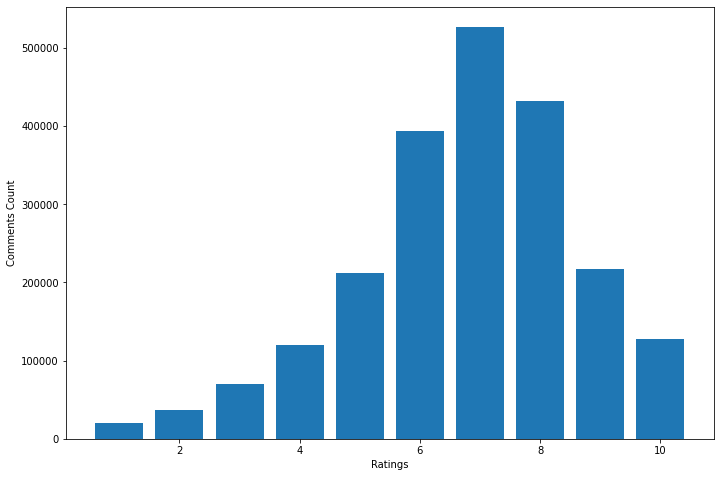

In [116]:
fig= plt.figure(figsize=(9,6))
ax = fig.add_axes([0,0,1,1])
ratings = [1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0]
comments_per_rating = []
for i in range(len(ratings)):
  comments_per_rating.append(train_df_n.rating.value_counts()[ratings[i]])
ax.bar(ratings,comments_per_rating)
ax.set_xlabel("Ratings")
ax.set_ylabel("Comments Count")
plt.show()

Thus it can be seen from the figure, the count of comments for rating 7 is the highest whereas there very few comments with rating 1

Now we can start cleaning the text. Comment will have same words in upper and lower case, it will have unwanted punctuations, html tags, unwanted space. So we need to deal with such comments and want our comments in same format.



In [0]:
train_df_n.tail()
train_na = train_df_n.to_numpy()

In [118]:
print(train_na[3][1])

This is probably the best game I ever played.  Requires more than just thinking; develops negotiation skills


In [0]:
for x in range(len(train_na[:,1])):
  txt=str(train_na[x][1])
  html_tags=re.compile('<.*?>');
  txt=re.sub(html_tags, '', txt);#remove html tags
  txt=re.sub(r"[^a-zA-Z0-9']+", ' ', txt);#just keep chars and number and remove rest all punctions
  txt=txt.lower()#convert to lower case
  txt = ' '.join([w for w in str(txt).split() if w not in (stop)])#remove stop words
  train_na[x][1]=txt

In [120]:
print(train_na[3][1])

probably best game ever played requires thinking develops negotiation skills


Random shuffle the records

In [0]:
np.random.shuffle(train_na)

In [122]:
print(train_na[3][1])

kickstarter


Split the data into train and test in the portion of 80 and 20 respectively.

In [0]:
X_train, X_test, y_train, y_test = train_test_split(train_na[:,1], train_na[:,0], test_size=0.20)

# 3.Word Count- Count Vectorizer

In [124]:
from sklearn.feature_extraction.text import CountVectorizer
com=X_train[0:3]
print(com)
vector_form=CountVectorizer()
vector_form.fit(com)

#Get the vocabulary generated
print("Vocabulary for the fiven small data is: ")
print(str(vector_form.vocabulary_)+"\n")
#Get the features generated
print("Features for the fiven small data is: ")
print(str(vector_form.get_feature_names())+"\n")

vector_array=vector_form.transform(com)

#get the shape of the vector array generated
print("Vector Array shape for the fiven small data is: ")
print(str(vector_array.shape)+"\n")
#get the vector array generated
print("Vector Array for the fiven small data is: ")
print(str(vector_array.toarray())+"\n")

['complaint cards small cards say tarot sized would much easier read'
 'purchased spiel essen 2017'
 "4 plays played game nazi's 3 times succession absolutely got asses kicked every time even close still blast fourth game figured scoring villains wrong game villains ramping power one game flew plane get temple crashed cliffhanger survived crash found car chased temple barely survived cliffhanger shot nazi henchmen made temple collapsed departed knocked cold woke disoriented home city moscow 3 turns tons events like throughout three games know game totally whack unbalanced impossible win much care great experience game i'll play rules heavy game detriment imho could wipe half rules counters combine decks cards without fundamentally changing fun game really adventure cards make game everything else accounting still worth mind seeing less version game"]
Vocabulary for the fiven small data is: 
{'complaint': 18, 'cards': 8, 'small': 80, 'say': 75, 'tarot': 85, 'sized': 79, 'would': 103, 'm

In [125]:
from sklearn.feature_extraction.text import CountVectorizer
#Vectorization
vector_form2=CountVectorizer()
Xtrain_tf=vector_form2.fit_transform(X_train)
print("Shape after Vectorization: ")
Xtrain_tf.shape

Shape after Vectorization: 


(2110204, 333822)

# 4.TF-IDF

In [126]:
from sklearn.feature_extraction.text import TfidfTransformer
vector_form=TfidfTransformer()

vector_form.fit(vector_array)
print("Frequency for all the features: ")#features frequency
print(str(vector_form.idf_)+"\n")
frequency=vector_form.transform(vector_array)
print("Weight for all the features: ")#feature weights
print(str(frequency.toarray())+"\n")

Frequency for all the features: 
[1.69314718 1.69314718 1.69314718 1.69314718 1.69314718 1.69314718
 1.69314718 1.69314718 1.28768207 1.69314718 1.69314718 1.69314718
 1.69314718 1.69314718 1.69314718 1.69314718 1.69314718 1.69314718
 1.69314718 1.69314718 1.69314718 1.69314718 1.69314718 1.69314718
 1.69314718 1.69314718 1.69314718 1.69314718 1.69314718 1.69314718
 1.69314718 1.69314718 1.69314718 1.69314718 1.69314718 1.69314718
 1.69314718 1.69314718 1.69314718 1.69314718 1.69314718 1.69314718
 1.69314718 1.69314718 1.69314718 1.69314718 1.69314718 1.69314718
 1.69314718 1.69314718 1.69314718 1.69314718 1.69314718 1.69314718
 1.69314718 1.69314718 1.69314718 1.69314718 1.69314718 1.69314718
 1.69314718 1.69314718 1.28768207 1.69314718 1.69314718 1.69314718
 1.69314718 1.69314718 1.69314718 1.69314718 1.69314718 1.69314718
 1.69314718 1.69314718 1.69314718 1.69314718 1.69314718 1.69314718
 1.69314718 1.69314718 1.69314718 1.69314718 1.69314718 1.69314718
 1.69314718 1.69314718 1.6931

In [127]:
from sklearn.feature_extraction.text import TfidfTransformer
vector_form3=TfidfTransformer()
Xtrain_tfid=vector_form3.fit_transform(Xtrain_tf)
print("Shape after TF-IDF: ")
Xtrain_tfid.shape

Shape after TF-IDF: 


(2110204, 333822)

In [0]:
y_train=y_train.astype(int)
y_test=y_test.astype(int)

# 5.Build Models

## A.MultinomialNM

In [0]:
from sklearn.naive_bayes import MultinomialNB
m1 = MultinomialNB().fit(Xtrain_tfid, y_train)

# Saving model to disk
pickle.dump(m1, open('model.pkl','wb'))

# Loading model to compare the results
model = pickle.load(open('model.pkl','rb'))

test_count=vector_form2.transform(X_test)
test_tfid=vector_form3.transform(test_count)
predict1=m1.predict(test_tfid)

In [130]:
print(predict)

[7 7 7 ... 7 8 8]


In [131]:
print("Accuracy score acieved for Multinomial NM: "+str(accuracy_score(y_test,predict1)))
print(metrics.classification_report(y_test,predict1))
# metrics.confusion_matrix(y_test,predict)

Accuracy score acieved for Multinomial NM: 0.2897212028387723


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.56      0.00      0.00      4272
           2       0.48      0.00      0.01      8037
           3       0.41      0.00      0.00     15131
           4       0.26      0.00      0.00     26907
           5       0.28      0.01      0.02     50402
           6       0.27      0.14      0.19    102563
           7       0.29      0.88      0.44    139137
           8       0.29      0.14      0.19    105906
           9       0.26      0.01      0.01     49865
          10       0.44      0.01      0.01     25330

    accuracy                           0.29    527552
   macro avg       0.32      0.11      0.08    527552
weighted avg       0.30      0.29      0.19    527552



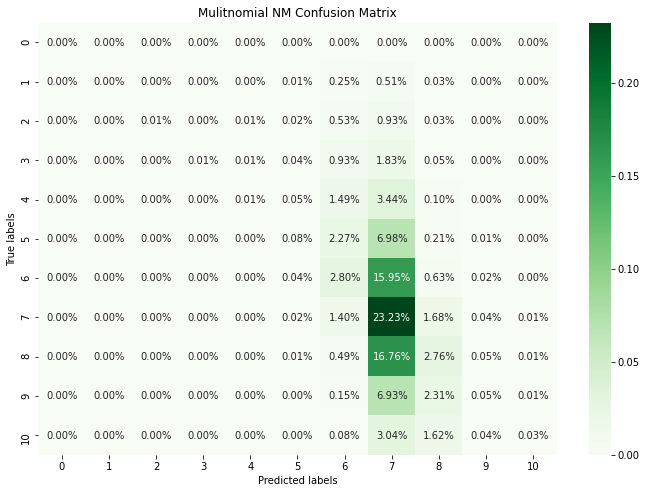

In [132]:
fig= plt.figure(figsize=(9,6))
ax = fig.add_axes([1,1,1,1])
cm = confusion_matrix(y_test, predict1)
sns.heatmap(cm/np.sum(cm), annot=True,ax = ax,fmt='0.2%', cmap='Greens')  
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Mulitnomial NM Confusion Matrix'); 

## B.Random Forest

In [133]:
vector_form2=CountVectorizer()
Xtrain_tf=vector_form2.fit_transform(X_train[0:10000])
print("Shape after Vectorization: ")
Xtrain_tf.shape

Shape after Vectorization: 


(10000, 19560)

In [134]:
from sklearn.feature_extraction.text import TfidfTransformer
vector_form3=TfidfTransformer()
Xtrain_tfid=vector_form3.fit_transform(Xtrain_tf)
print("Shape after TF-IDF: ")
Xtrain_tfid.shape

Shape after TF-IDF: 


(10000, 19560)

In [0]:
test_count=vector_form2.transform(X_test[10001:15000])
test_tfid=vector_form3.transform(test_count)

### i. K-fold

In [135]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import model_selection
rand_model=RandomForestClassifier(max_depth=3)
rand_model_cv=cross_val_score(rand_model,Xtrain_tfid, y_train[0:10000],cv=3)
print(rand_model_cv.mean())

0.27369998547545216


In [136]:
rand_model_cv=cross_val_score(rand_model,Xtrain_tfid, y_train[0:10000],cv=4)
print(rand_model_cv.mean())

0.2737


In [137]:
rand_model_cv=cross_val_score(rand_model,Xtrain_tfid, y_train[0:10000],cv=5)
print(rand_model_cv.mean())

0.27370000000000005


It seems cross value for 5 gives better precision compared to other. So let us create model using it.

In [142]:
m2=RandomForestClassifier(max_depth=3)
m2.fit(Xtrain_tfid, y_train[0:10000])
predict2=m2.predict(test_tfid)
print("Accuracy score acieved for Random Forest Tree: "+str(accuracy_score(y_test[10001:15000],predict2)))
print(metrics.classification_report(y_test[10001:15000],predict2))

Accuracy score acieved for Random Forest Tree: 0.26585317063412683
              precision    recall  f1-score   support

           1       0.00      0.00      0.00        43
           2       0.00      0.00      0.00        71
           3       0.00      0.00      0.00       155
           4       0.00      0.00      0.00       271
           5       0.00      0.00      0.00       474
           6       0.00      0.00      0.00       969
           7       0.27      1.00      0.42      1329
           8       0.00      0.00      0.00      1007
           9       0.00      0.00      0.00       444
          10       0.00      0.00      0.00       236

    accuracy                           0.27      4999
   macro avg       0.03      0.10      0.04      4999
weighted avg       0.07      0.27      0.11      4999



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


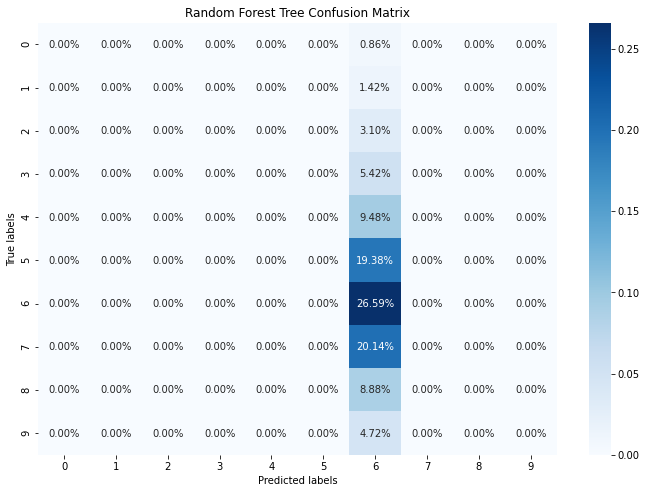

In [143]:
fig= plt.figure(figsize=(9,6))
ax = fig.add_axes([1,1,1,1])
cm = confusion_matrix(y_test[10001:15000],predict2)
sns.heatmap(cm/np.sum(cm), annot=True,ax = ax,fmt='0.2%', cmap='Blues')  
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Random Forest Tree Confusion Matrix'); 

## C.SVC

In [144]:
from sklearn.pipeline import Pipeline
from sklearn import svm
# pipeline = Pipeline([
#     ('count_vectorizer', CountVectorizer(lowercase = True, stop_words = stopwords.words('english'))), 
#     ('tfidf_transformer',  TfidfTransformer()), #weighs terms by importance to help with feature selection
#     ('classifier', svm.SVC(kernel='linear', C = 1.0)) ])

# pipeline.fit(X_train[0:10000], y_train[0:10000].astype('int'))

from sklearn.svm import SVC
m3 = SVC(kernel = 'linear', random_state = 0)
m3.fit(Xtrain_tfid, y_train[0:10000])

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=0, shrinking=True, tol=0.001,
    verbose=False)

In [0]:
#predict=pipeline.predict(X_test[10001:15000])
predict3=m3.predict(test_tfid)

In [146]:
print("Accuracy score acieved for SVM: "+str(accuracy_score(y_test[10001:15000],predict3)))
print(metrics.classification_report(y_test[10001:15000],predict3))

Accuracy score acieved for SVM: 0.27985597119423883
              precision    recall  f1-score   support

           1       0.00      0.00      0.00        43
           2       0.00      0.00      0.00        71
           3       0.00      0.00      0.00       155
           4       0.37      0.07      0.11       271
           5       0.23      0.07      0.11       474
           6       0.24      0.24      0.24       969
           7       0.28      0.58      0.38      1329
           8       0.30      0.31      0.31      1007
           9       0.29      0.05      0.08       444
          10       0.35      0.04      0.07       236

    accuracy                           0.28      4999
   macro avg       0.21      0.14      0.13      4999
weighted avg       0.27      0.28      0.24      4999



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


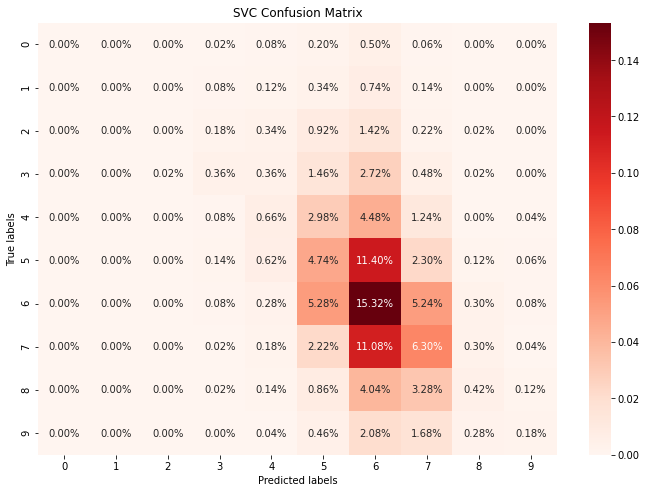

In [147]:
fig= plt.figure(figsize=(9,6))
ax = fig.add_axes([1,1,1,1])
cm = confusion_matrix(y_test[10001:15000],predict3)
sns.heatmap(cm/np.sum(cm), annot=True,ax = ax,fmt='0.2%', cmap='Reds')  
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('SVC Confusion Matrix'); 

### i.Hyper-parameter tuning

In [0]:
from sklearn.model_selection import GridSearchCV
parameters = [{'C': [1, 10], 'kernel': ['linear']},
              {'C': [1, 10], 'kernel': ['rbf'], 'gamma': [0.5, 0.7, 0.9]}]
grid_search = GridSearchCV(estimator = m3,
                           param_grid = parameters,
                           scoring = 'accuracy',
                           cv = 10,
                           n_jobs = -1)
grid_search = grid_search.fit(Xtrain_tfid, y_train[0:10000])

In [0]:
accuracy=grid_search.best_score_

In [152]:
accuracy

0.2954

In [154]:
grid_search.best_params_

{'C': 1, 'gamma': 0.5, 'kernel': 'rbf'}

In [156]:
m4 = SVC(kernel = 'rbf', C=1,gamma=0.7)
m4.fit(Xtrain_tfid, y_train[0:10000])
predict=m4.predict(test_tfid)
print("Accuracy score acieved for SVM after hyper paratemeter tuning: "+str(accuracy_score(y_test[10001:15000],predict4)))
print(metrics.classification_report(y_test[10001:15000],predict4))

Accuracy score acieved for SVM after hyper paratemeter tuning: 0.26585317063412683
              precision    recall  f1-score   support

           1       0.00      0.00      0.00        43
           2       0.00      0.00      0.00        71
           3       0.00      0.00      0.00       155
           4       0.00      0.00      0.00       271
           5       0.00      0.00      0.00       474
           6       0.00      0.00      0.00       969
           7       0.27      1.00      0.42      1329
           8       0.00      0.00      0.00      1007
           9       0.00      0.00      0.00       444
          10       0.00      0.00      0.00       236

    accuracy                           0.27      4999
   macro avg       0.03      0.10      0.04      4999
weighted avg       0.07      0.27      0.11      4999



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# 6.Compare different models and select best model 

In [158]:
print("Accuracy for all the models generated so far:")
print("\nMultinomialNM: "+str('28.97212028387723%'))
print("\nRandom Forest Tree: "+str('26.585317063412683%'))
print("\nSVC: "+str('27.985597119423883%'))
print("\nSVC after hyper-parameter tuning: "+str('26.585317063412683%'))

Accuracy for all the models generated so far:

MultinomialNM: 28.97212028387723%

Random Forest Tree: 26.585317063412683%

SVC: 27.985597119423883%

SVC after hyper-parameter tuning: 26.585317063412683%


Finally the accuracy of Multinomial NM is highest among other models so we are finalizing this model.

Reference:

https://www.analyticsvidhya.com/blog/2018/08/dask-big-datasets-machine_learning-python/
</br>https://www.youtube.com/watch?v=xvqsFTUsOmc
</br>https://www.kaggle.com/szelee/how-to-import-a-csv-file-of-55-million-rows
</br>https://www.youtube.com/watch?v=dq73Ghk3MQg
</br>https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea
</br>https://www.youtube.com/watch?v=gJRhXp8Sm4Y
</br>https://towardsdatascience.com/the-best-format-to-save-pandas-data-414dca023e0d
</br>https://www.youtube.com/user/krishnaik06

### Improvements made:

Firstly, the main issue for this project was handling the size of dataset which is above 1GB. So gathering data has many approaches like chunks, dask, pyspark and finally comparing all the three methods picked the best sutable approach.</br></br>
Second improvement is using the feather to access the dataset in the dataframe. Using feather helped me to access easily and quickly.</br></br>
Moreover, I have seen lot of model generating which used pipeline directly, so made a for loop to clean the text like removing html tags, punctuation, numeric values, extra space, converting upper to lower case, removing stopwords.</br></br>
Next used the K-fold for the Random forest tree model which calculates the average of all the folds and find optimal model.</br></br>
Hyper Parameter tuning on the SVC model to get the optimal approach.

### Challenges faced:

Challenge implementing the Random forest tree and SVC model.
</br></br>
Dealing with the large dataset for building the notebook.
</br></br>
Uploading the working app on the server. There are many solutions available online but the size of their model were less than 25 MB. I used Heroku for deploying the project but requires to upload on Git however my model was greater than 100mb due to which I had to use Git lfs plus heroku also needs lfs build pack along with token.